### 1. Business Understanding

Problem Statement:  Prediction of Arrival Delay

Project Objective: (1) Regression Model (2) Model Deployment

### 2. Data Understanding

#### Data collection - ดึงไฟล์ 2008.csv จาก s3.amazonaws.com มาไว้ใน Linux File System

In [1]:
! wget https://s3.amazonaws.com/imcbucket/data/flights/2008.csv

--2021-11-04 07:54:06--  https://s3.amazonaws.com/imcbucket/data/flights/2008.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.26.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.26.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689413344 (657M) [binary/octet-stream]
Saving to: ‘2008.csv’

2008.csv            100%[===================>] 657.48M  76.4MB/s    in 8.7s    

2021-11-04 07:54:15 (75.3 MB/s) - ‘2008.csv’ saved [689413344/689413344]



#### นับจำนวนบรรทัดในไฟล์ 2008.csv

In [2]:
! wc -l ./2008.csv

7009729 ./2008.csv


#### ดู Content ในไฟล์ 2008.csv

In [3]:
! head -3 2008.csv

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2008,1,3,4,2003,1955,2211,2225,WN,335,N712SW,128,150,116,-14,8,IAD,TPA,810,4,8,0,,0,NA,NA,NA,NA,NA
2008,1,3,4,754,735,1002,1000,WN,3231,N772SW,128,145,113,2,19,IAD,TPA,810,5,10,0,,0,NA,NA,NA,NA,NA


#### ลบ Directory และไฟล์ 2008.csv ที่มีอยู่เดิมใน HDFS

In [4]:
! hdfs dfs -rm -f /user/cloudera/input/2008.csv

#### สร้าง Directory "input" ใน HDFS

In [5]:
! hdfs dfs -mkdir -p /user/cloudera/input

#### Copy ไฟล์ 2008.csv จาก Linux File System ไปไว้ใน Directory "input" ของ HDFS

In [6]:
! hadoop fs -put 2008.csv /user/cloudera/input

#### แสดงและตรวจดูให้แน่ใจว่ามีไฟล์ 2008.csv อยู่ใน "input"

In [7]:
! hdfs dfs -ls /user/cloudera/input

Found 1 items
-rw-r--r--   2 root hadoop  689413344 2021-11-04 07:54 /user/cloudera/input/2008.csv


#### Spark อ่านไฟล์ 2008.csv จาก HDFS มาเป็น DataFrame

In [8]:
airline_df = spark.read.format('csv').\
option('header','true').option('mode','DROPMALFORMED')\
.load('/user/cloudera/input/2008.csv')

In [79]:
airline_df.rdd.getNumPartitions()

6

In [83]:
smaller_df = airline_df.repartition(100).cache()

In [84]:
smaller_df.rdd.getNumPartitions()

100

#### Spark นับจำนวน tuple ใน DataFrame

In [9]:
airline_df.count()

7009728

#### Spark: Assign ค่าของตัวแปรเก่า ให้กับตัวแปรใหม่

In [10]:
airline_row_df = airline_df

#### Spark แสดง Schema ของข้อมูลใน DataFrame

In [11]:
airline_row_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

### 3. Data Preparation

#### Spark เรียกใช้ Data Types และ Functions ต่างๆ สำหรับจัดการข้อมูลใน DataFrame

In [12]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf

In [13]:
crunched_df = airline_row_df.\
withColumn('DepTime',airline_row_df['DepTime'].\
           cast(DoubleType())).\
withColumn('TaxiOut',airline_row_df['TaxiOut'].\
           cast(DoubleType())).\
withColumn('TaxiIn',airline_row_df['TaxiIn'].\
           cast(DoubleType())).\
withColumn('DepDelay',airline_row_df['DepDelay'].\
           cast(DoubleType())).\
withColumn('DayOfWeek',airline_row_df['DayOfWeek'].\
           cast(DoubleType())).\
withColumn('Distance',airline_row_df['Distance'].\
           cast(DoubleType())).\
withColumn('ArrDelay',airline_row_df['ArrDelay'].\
           cast(DoubleType()))

#### Spark แสดง Schema ของข้อมูลใน DataFrame หลังจาก cast type แล้ว

In [14]:
crunched_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- DayofMonth: string (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: string (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay:

#### Python ติดตั้ง Module "pandas"

In [15]:
! pip install pandas

#### Spark ทำ Data Exploratory โดยใช้สถิติเบื้องต้นกับข้อมูลใน DataFrame

In [16]:
import pandas as pd
pd.DataFrame(crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().take(6),\
             columns=crunched_df.\
             select(['DepTime','TaxiOut','TaxiIn',\
                     'DayOfWeek','Distance','ArrDelay']).\
             describe().columns).transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
DepTime,6873482,1333.8300461105448,478.0688948662984,1.0,2400.0
TaxiOut,6872670,16.453045177492882,11.332798654232155,0.0,429.0
TaxiIn,6858079,6.860851704974527,4.933649371300466,0.0,308.0
DayOfWeek,7009728,3.9241815088973495,1.988258945985121,1.0,7.0
Distance,7009728,726.3870294253928,562.10180348404,11.0,4962.0
ArrDelay,6855029,8.16845238729114,38.50193694882867,-519.0,2461.0


#### Spark ทำ Data Transformation โดยใช้ Data Discretization กับ "DepTime" ใน DataFrame

In [17]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [18]:
timeperiod = udf(lambda x: t_timeperiod(x),StringType())

In [19]:
discretized_df = crunched_df.\
withColumn('DepTime',timeperiod(crunched_df['DepTime']))

#### Spark ทำ Data Transformation โดยใช้ Data Normalization กับ "Distance" และ "ArrDelay" ใน DataFrame

In [20]:
from pyspark.sql.functions import *
max_distance = discretized_df.select(max('Distance')).collect()[0][0]
min_distance = discretized_df.select(min('Distance')).collect()[0][0]

In [21]:
max_ArrDelay = discretized_df.select(max('ArrDelay')).collect()[0][0]
min_ArrDelay = discretized_df.select(min('ArrDelay')).collect()[0][0]

In [22]:
def t_normalized_distance(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_distance)/(max_distance-min_distance))

In [23]:
def t_normalized_ArrDelay(origin):
    if origin is None:
        return None
    else:
        return ((origin-min_ArrDelay)/(max_ArrDelay-min_ArrDelay))

In [24]:
normalized_distance = udf(lambda x: t_normalized_distance(x),DoubleType())

In [25]:
normalized_ArrDelay = udf(lambda x: t_normalized_ArrDelay(x),DoubleType())

In [26]:
normalized_df = discretized_df.\
withColumn('Distance', normalized_distance(discretized_df['Distance'])).\
withColumn('ArrDelay', normalized_ArrDelay(discretized_df['ArrDelay']))

#### Spark ทำ Feature Selection ด้วยการเลือกเฉพาะบาง Attributes มาเป็น Features

In [27]:
features_df = normalized_df.\
select(['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay'])

#### Spark กำจัดค่า Null ด้วยการลบทั้ง Tuple (Record) เมื่อพบว่ามี Attribute ใดมีค่า Null

In [28]:
final_df = features_df.dropna()

#### Spark นับจำนวน tuple ใน DataFrame

In [29]:
final_df.count()

6855029

In [30]:
final_df.show()

+-------------+------+----+-----------+-------+------+--------+---------+--------------------+-------------------+
|UniqueCarrier|Origin|Dest|    DepTime|TaxiOut|TaxiIn|DepDelay|DayOfWeek|            Distance|           ArrDelay|
+-------------+------+----+-----------+-------+------+--------+---------+--------------------+-------------------+
|           WN|   IAD| TPA|18.00-24.00|    8.0|   4.0|     8.0|      4.0| 0.16138153908301353|0.16946308724832215|
|           WN|   IAD| TPA|06.00-11.59|   10.0|   5.0|    19.0|      4.0| 0.16138153908301353|0.17483221476510066|
|           WN|   IND| BWI|06.00-11.59|   17.0|   3.0|     8.0|      4.0|  0.1017976166431024|0.17885906040268457|
|           WN|   IND| BWI|06.00-11.59|    7.0|   3.0|    -4.0|      4.0|  0.1017976166431024|0.17214765100671142|
|           WN|   IND| BWI|18.00-24.00|   10.0|   3.0|    34.0|      4.0|  0.1017976166431024| 0.1855704697986577|
|           WN|   IND| JAX|18.00-24.00|   10.0|   4.0|    25.0|      4.0|  0.136

### 4. Modeling (and making some data transformation )

#### Spark แบ่งข้อมูลเป็น training set และ test set

In [31]:
training_df,test_df = final_df.\
randomSplit([0.20,0.80], seed = 12)

#### Spark นับจำนวน tuple ใน DataFrame

In [32]:
training_df.count()

1370679

#### Spark แสดง Schema ของ training set

In [33]:
training_df.printSchema()

root
 |-- UniqueCarrier: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- DayOfWeek: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- ArrDelay: double (nullable = true)



#### Transformation categorical variable to numerical one.

In [34]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder

In [35]:
DepTimeIndexer = StringIndexer\
(inputCol='DepTime',outputCol='DepTimeIndexed')

In [36]:
UniqueCarrierIndexer = StringIndexer\
(inputCol='UniqueCarrier',\
 outputCol='UniqueCarrierIndexed')

In [37]:
UniqueCarrierOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='UniqueCarrierIndexed',\
 outputCol='UniquecarrierVec')

In [38]:
OriginIndexer = StringIndexer(inputCol='Origin',\
                              outputCol='OriginIndexed')

In [39]:
OriginOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='OriginIndexed',\
 outputCol='OriginVec')

In [40]:
DestIndexer = StringIndexer(inputCol='Dest',\
                            outputCol='DestIndexed')

In [41]:
DestOneHotEncoder = OneHotEncoder\
(dropLast=False,inputCol='DestIndexed',\
 outputCol='DestVec')

In [42]:
#labelIndexer = StringIndexer(inputCol='ArrDelay',outputCol='labelIndexed')

#### Combines a selected columns into a single vector column.

In [43]:
from pyspark.mllib.linalg import Vectors

In [44]:
from pyspark.ml.feature import VectorAssembler

In [45]:
from pyspark.ml import Pipeline

In [46]:
featureAssembler = VectorAssembler\
(inputCols=['UniqueCarrierIndexed',\
            'OriginVec',\
            #'DestVec',\
            'DepTimeIndexed',\
            'TaxiOut','TaxiIn',\
            'DepDelay',\
            'DayOfWeek',\
            'Distance'
           ], outputCol='***features')

#### Define an algorithm.

In [47]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression

In [48]:
dt = LinearRegression\
(labelCol='ArrDelay',featuresCol='***features')

#### Pipeline.

In [49]:
pipeline_dt = Pipeline().\
setStages([UniqueCarrierIndexer,\
           UniqueCarrierOneHotEncoder,\
           DepTimeIndexer,\
           #DepTimeOneHotEncoder,\
           OriginIndexer ,\
           OriginOneHotEncoder,\
           DestIndexer,\
           DestOneHotEncoder,\
           featureAssembler,dt])

In [50]:
#training_df.count()

#### Launch the pipeline and get a model.

In [ ]:
dtModel = pipeline_dt.fit(training_df)

In [85]:
dtModel

PipelineModel_1aca580ba8e8

#### print out model structure

In [ ]:
#tree = dtModel.stages[9]

In [ ]:
#tree.toDebugString

### 5. Evaluation

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null

In [ ]:
result_df = dtModel.transform(test_df.dropna())

#### แสดงผลลัพธ์เปรียบเทียบระหว่าง Arrival Delay จริง กับ Prediction of Arrival Delay

In [ ]:
result_df.select(['ArrDelay','Prediction']).show()

+-------------------+-------------------+
|           ArrDelay|         Prediction|
+-------------------+-------------------+
|0.16845637583892617| 0.1713888583349105|
|0.17281879194630873| 0.1742807177193084|
|0.16711409395973154|0.17253353039315494|
| 0.1644295302013423|0.16947208437960806|
|0.17348993288590603| 0.1734504517847117|
|0.17114093959731544| 0.1729972501650144|
| 0.1704697986577181|0.17270360479319308|
|0.17718120805369128| 0.1780808778194822|
|0.18053691275167785|0.18029046026047404|
|0.17013422818791946| 0.1744847943192996|
|0.17214765100671142|0.17531175625362172|
|0.17315436241610738|0.17578759023532092|
|0.21577181208053692| 0.2181585698143785|
|0.20536912751677852|0.20337906041419834|
|0.17114093959731544|0.17354060866068044|
|0.17315436241610738|  0.175680211025455|
|0.17818791946308724| 0.1775351682468789|
|0.17281879194630873|0.17709427783657788|
|0.17885906040268457|  0.178440727200313|
| 0.1761744966442953| 0.1767008284930908|
+-------------------+-------------

#### Plot a Graph

In [ ]:
! pip install pandas

In [ ]:
#sample for 7000 row from 1361937 millions
lr_prediction_sample = result_df.select("prediction","ArrDelay")
lr_prediction_sample1 = lr_prediction_sample.limit(3500)
lr_prediction_sample2 = lr_prediction_sample1.sort("ArrDelay", ascending=True)
#convert to pandas
lr_prediction_sample_pd = lr_prediction_sample1.toPandas()

In [ ]:
print(lr_prediction_sample_pd.info())
lr_prediction_sample_pd.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
prediction    3500 non-null float64
ArrDelay      3500 non-null float64
dtypes: float64(2)
memory usage: 54.8 KB
None


,prediction,ArrDelay
0,0.171389,0.168456
1,0.174281,0.172819
2,0.172534,0.167114
3,0.169472,0.164430
4,0.173450,0.173490


In [ ]:
lr_prediction_sample_pd['id'] = lr_prediction_sample_pd.index

In [ ]:
! pip install seaborn

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

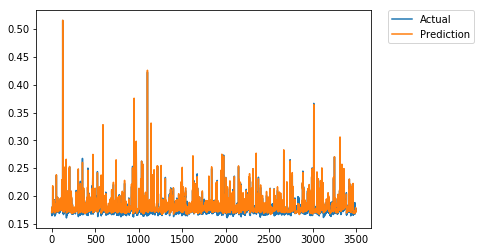

In [ ]:
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['ArrDelay'],label='Actual')
#plt.plot(cv_prediction_sample_pd['id'] , cv_prediction_sample_pd['prediction'],label='CV_Prediction')
plt.plot(lr_prediction_sample_pd['id'] , lr_prediction_sample_pd['prediction'],label='Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.001)
plt.show()

In [ ]:
training_df.count()

1370679

#### กรองบาง Tuples (Records) ทิ้งไปจาก testing set

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
new_test_df1 = test_df.filter(test_df.Origin != 'TUP')\
.filter(test_df.Origin != 'PIR')\
.filter(test_df.Dest != 'TUP')\
.filter(test_df.Dest != 'PIR')\
.filter(test_df.Origin != 'PUB')\
.filter(test_df.DepTime != '425')\
.filter(test_df.DepTime != '328')\
.filter(test_df.DepTime != '437')\
.filter(test_df.DepTime != '400')\
.filter(test_df.DepTime != '414')\
.filter(test_df.DepTime != '424')\
.filter(test_df.DepTime != '439')\
.filter(test_df.DepTime != '338')\
.filter(test_df.DepTime != '359')\
.filter(test_df.DepTime != '412')\
.filter(test_df.DepTime != '430')

#### นำโมเดลมาทำ Prediction ด้วยข้อมูล testing set ที่ไม่มีค่า Null และผ่านการกรองฯ แล้ว

In [ ]:
everesult_df = dtModel.transform(new_test_df1.dropna())

In [ ]:
lr_evaluator_r2 = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" \
      % lr_evaluator_r2.evaluate(everesult_df))

R Squared (R2) on test data = 0.939843


In [ ]:
lr_evaluator_rmse = RegressionEvaluator\
(predictionCol="prediction",labelCol="ArrDelay",metricName="rmse")
print("Root Mean Squared Error (RMSE) on test data = %g" \
      % lr_evaluator_rmse.evaluate(everesult_df))

Root Mean Squared Error (RMSE) on test data = 0.00316979


dtModel.stages[-1].featureImportances

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

ExtractFeatureImp(dtModel.stages[-1].featureImportances, everesult_df, "***features").head(10)

In [ ]:
numeric_feature = [
            'TaxiOut','TaxiIn',\
            'DepDelay',\
            'DayOfWeek',\
            'Distance'
           ]

In [ ]:
training_pd = training_df.toPandas()

In [ ]:
! pip install 

In [72]:
from pandas.plotting import scatter_matrix

#scatter_matrix(iris_df, alpha=0.2, figsize=(10, 10))

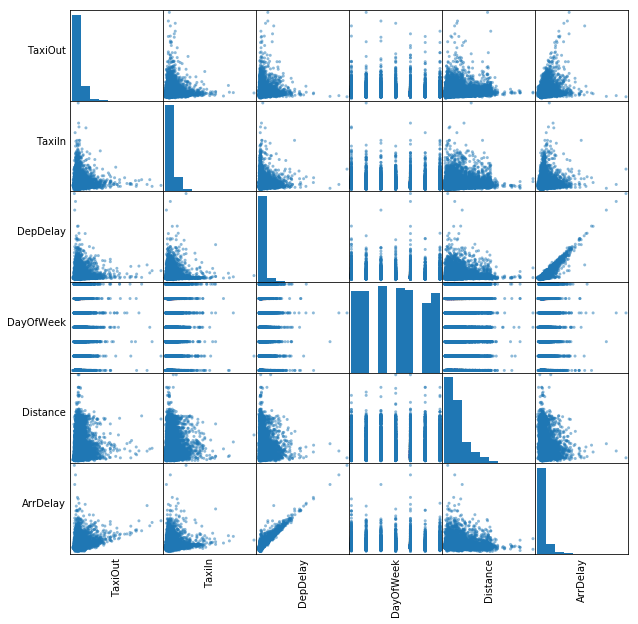

In [73]:
import pandas as pd
numeric_features = [t[0] for t in training_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = training_df.select(numeric_features).sample(False, 0.01).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [74]:
training_df

DataFrame[UniqueCarrier: string, Origin: string, Dest: string, DepTime: string, TaxiOut: double, TaxiIn: double, DepDelay: double, DayOfWeek: double, Distance: double, ArrDelay: double]

In [75]:
everesult_df

DataFrame[UniqueCarrier: string, Origin: string, Dest: string, DepTime: string, TaxiOut: double, TaxiIn: double, DepDelay: double, DayOfWeek: double, Distance: double, ArrDelay: double, UniqueCarrierIndexed: double, UniquecarrierVec: vector, DepTimeIndexed: double, OriginIndexed: double, OriginVec: vector, DestIndexed: double, DestVec: vector, ***features: vector, prediction: double]

In [76]:
dtModel

PipelineModel_1aca580ba8e8